In [5]:
#import Pkg; Pkg.add("FFTW")

using FFTW, Plots

In [ ]:
N = 63;
P = 1.0;
Δt = P / N
x = 0.0:Δt:(P-Δt)   # lenght(x) == N
y = [sin(2π*7*t) + sin(2π*15*t) + cos(2π*30*t) for t in x] # mixture of simple wave signal
plot(x, y, legend = false, linewidth=2)
Fy = fft(y)[1:N÷2]
ak =  2/N * real.(Fy)
bk = -2/N * imag.(Fy)  # fft sign convention
ak[1] = ak[1]/2
yr = zeros(N,1)
for i in 1:N÷2
    yr .+= ak[i] * cos.(2π*(i-1)/P * x) .+ bk[i] * sin.(2π*(i-1)/P * x)
end
plot!(x, yr, linestyle=:dash, linewidth=2)
ak[ak.<1e-14] .= 0.0
bk[bk.<1e-14] .= 0.0
println(ak)
println(bk)

In [ ]:
function fourier_decompose(f, M)
    N = M+1
    Δθ = π / (N+1)
    x = 0.0:Δθ:(2π-Δθ)
    y = [f(θ) for θ in x]
    Fy = fft(y)[1:N]
    Cc =  real.(Fy) / (N + 1)
    Sc = -imag.(Fy) / (N + 1)  # fft sign convention
    Cc[1] = 0.5 * Cc[1]
    Sc[1] = 0.0
    return Cc, Sc
end

In [ ]:
N = 10
C = randn(N+1)
S = randn(N+1)
S[1] = 0.0

function f(θ)
    ms = 0:N
    return sum(C.*cos.(ms .* θ) .+ S.*sin.(ms .* θ))
end
Cc, Sc = fourier_decompose(f, N)
println(C-Cc)
println(S-Sc)

In [6]:
using FiniteElementHermite

function fourier_decompose(f, M::Integer)
    Δθ = π / (M+2)
    x = 0.0:Δθ:(2π-Δθ)
    y = [f(θ) for θ in x]
    Fy = fft(y)[1:(M+1)]
    Cc =  real.(Fy) / (M + 2)
    Sc = -imag.(Fy) / (M + 2)  # fft sign convention
    Cc[1] = 0.5 * Cc[1]
    Sc[1] = 0.0
    return collect(Iterators.flatten(zip(Cc, Sc)))
end

ρIP_f_nu(θ, f, nu, k, ρ) = inner_product(x -> f(x,θ), nu, k, ρ)

function θFD_ρIP_f_nu(f, nu, k, ρ, M)

    return fourier_decompose(θ -> ρIP_f_nu(θ, f, nu, k, ρ), M)

end

θFD_ρIP_f_nu (generic function with 1 method)

In [7]:
f(ρ,θ) = ρ^2 * cos(3θ)
N = 11
M = 5

ρ = range(0, 1, N)

B = zeros(2*N,2(M+1))
for j in 1:N
    B[2j-1,:] = θFD_ρIP_f_nu(f,νo,j,ρ,M)
    B[2j  ,:] = θFD_ρIP_f_nu(f,νe,j,ρ,M)
end
println(B[:,8])

[6.134350795973983e-22, 2.5183087685383794e-20, 4.7650012119545194e-21, 4.406800801234368e-19, 8.402161430283496e-21, 1.6117176118645628e-18, 1.7068735654873356e-20, 3.719192273401071e-18, 2.2927405698132708e-20, 6.2318223594320156e-18, 2.4740894131108636e-20, 9.033909480662771e-18, 2.2513717645094802e-20, 1.3910351758377505e-17, 4.3618242826486793e-20, 1.835961682336646e-17, 4.4033184166806465e-20, 2.5787481789833005e-17, 2.5595591329467904e-20, 2.95831665423073e-17, -2.9897848989094954e-19, 1.6724417941607213e-17]


In [ ]:
# using BandedMatrices
# As = zeros(2N,7)
# for j in 1:N
#    # First odd with all nearest neighbors
#    As[2j-1, 1] = 0.0
#    if j > 1
#        As[2j-1, 2] = inner_product(νo, j, νo, j-1, ρ)
#        As[2j-1, 3] = inner_product(νo, j, νe, j-1, ρ)
#    end
#    As[2j-1, 4] = inner_product(νo, j, νo, j, ρ)
#    As[2j-1, 5] = inner_product(νo, j, νe, j, ρ)
#    if j < N
#        As[2j-1, 6] = inner_product(νo, j, νo, j+1, ρ)
#        As[2j-1, 7] = inner_product(νo, j, νe, j+1, ρ)
#     end

#     # Then even with all nearest neighbors
#     if j > 1
#         As[2j, 1] = inner_product(νe, j, νo, j-1, ρ)
#         As[2j, 2] = inner_product(νe, j, νe, j-1, ρ)
#     end
#     As[2j, 3] = inner_product(νe, j, νo, j, ρ)
#     As[2j, 4] = inner_product(νe, j, νe, j, ρ)
#     if j < N
#         As[2j, 5] = inner_product(νe, j, νo, j+1, ρ)
#         As[2j, 6] = inner_product(νe, j, νe, j+1, ρ)
#     end
#     As[2j, 7] = 0.0
# end
# A = BandedMatrix(-3 => As[4:end,1], -2 => As[3:end,2],   -1 => As[2:end,3], 0 => As[:,4],
#     1 => As[1:end-1,5],  2 => As[1:end-2,6], 3 => As[1:end-3,7]);

In [8]:
A = mass_matrix(N, ρ)

X = zeros(2*N,2(M+1))

for k in 1:(2(M+1))
    X[:,k] = A \ B[:,k]
end
println(X[:,7])

[6.960577947356938e-15, -7.006656539687574e-17, 0.20000000000000184, 0.009999999999999966, 0.3999999999999883, 0.039999999999999855, 0.5999999999999698, 0.09000000000000008, 0.7999999999999949, 0.15999999999999995, 0.9999999999999306, 0.24999999999999956, 1.1999999999998756, 0.35999999999999976, 1.3999999999998496, 0.4900000000000004, 1.5999999999999552, 0.6400000000000006, 1.8000000000000098, 0.8100000000000008, 2.000000000000158, 1.000000000000002]


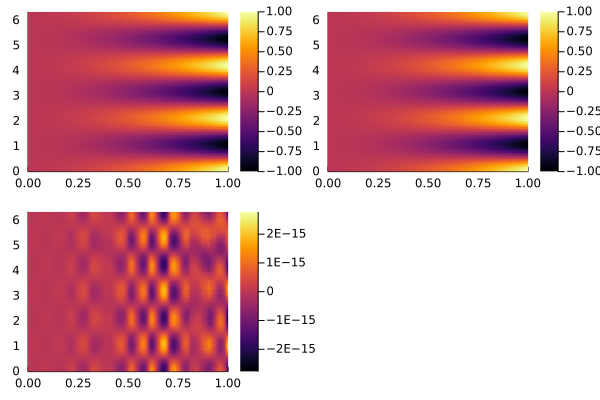

In [10]:
xs = range(0,1,1001)
ts = range(0,2π,101)

g(x, t) = sum([X[2i-1,2m+1]*νo(x,i,ρ)*cos(m*t) + X[2i,2m+1]*νe(x,i,ρ)*cos(m*t) + 
               X[2i-1,2m+2]*νo(x,i,ρ)*sin(m*t) + X[2i,2m+2]*νe(x,i,ρ)*sin(m*t)  for i in 1:N, m in 0:M])

F = [f(x,t) for t in ts, x in xs]
G = [g(x,t) for t in ts, x in xs]

p1 = heatmap(xs,ts,F)
p2 = heatmap(xs,ts,G)
p3 = heatmap(xs,ts,F-G)
p = plot(p1,p2,p3)
display(p)